In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

### 1.1 讀取資料

In [3]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', usecols=['Text', 'Score'])
df = df.head(10000)

In [4]:
# 顯示前 50 行
df.head(50)

# 或顯示最後 20 行
#df.tail(20)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...
5,4,I got a wild hair for taffy and ordered this f...
6,5,This saltwater taffy had great flavors and was...
7,5,This taffy is so good. It is very soft and ch...
8,5,Right now I'm mostly just sprouting this so my...
9,5,This is a very healthy dog food. Good for thei...


In [5]:
# 將 "Score" 轉為 1 (positive) 或 0 (negative)
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)
df = df[['Text', 'Sentiment']]  # 只保留 'Text' 和 'Sentiment'

# 顯示前 50 筆處理後的資料
df.head(50)

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1
5,I got a wild hair for taffy and ordered this f...,1
6,This saltwater taffy had great flavors and was...,1
7,This taffy is so good. It is very soft and ch...,1
8,Right now I'm mostly just sprouting this so my...,1
9,This is a very healthy dog food. Good for thei...,1


### 1.2 去除停頓詞 stop words

In [6]:
# 使用 sklearn 的預設停頓詞並擴展自訂停頓詞
stop_words = list(ENGLISH_STOP_WORDS) + ['additional', 'words']

# 使用 pandas 方法將 list 轉換為 Series，並顯示停頓詞
stop_words_series = pd.Series(stop_words)
stop_words_series.head(50)

0          since
1             of
2           such
3      somewhere
4       latterly
5             un
6         myself
7           were
8           five
9          until
10          ever
11           all
12          whom
13          many
14            de
15            an
16           few
17       because
18         yours
19         under
20            if
21           may
22        seemed
23        within
24        should
25          part
26         third
27       besides
28    throughout
29           can
30       thereby
31       whereas
32           him
33          full
34           you
35        twenty
36       another
37       whether
38         whole
39       serious
40            no
41       nothing
42        toward
43      anything
44           get
45         their
46      everyone
47          last
48      together
49         found
dtype: object

### 1.3 文字探勘前處理：將文字轉換成向量

In [7]:
# 使用 tf-idf 向量化

# 初始化 TfidfVectorizer，並移除停頓詞
tfidf = TfidfVectorizer(stop_words=stop_words)
X_tfidf = tfidf.fit_transform(df['Text'])

# 顯示 TF-IDF 向量的特徵名稱
tfidf_feature_names = tfidf.get_feature_names_out()
print("TF-IDF Feature Names: ", tfidf_feature_names[:10])  # 顯示前10個特徵

TF-IDF Feature Names:  ['00' '000' '0003' '000kwh' '002' '008' '0100' '0174' '02' '03']


### 使用 Word2Vec 向量化

In [8]:
# 確保 nltk 的 punkt 模組已經下載，進行文本分詞
nltk.download('punkt')

# 進行文本分詞
tokenized_texts = [word_tokenize(text.lower()) for text in df['Text']]

# 訓練 Word2Vec 模型
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, workers=4)

# 查詢 Word2Vec 向量，顯示 'good' 這個詞的向量
word_vectors = word2vec_model.wv
print("Word2Vec Example for 'good': ", word_vectors['good'])  # 查詢詞'good'的向量


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Word2Vec Example for 'good':  [ 1.0804713   0.22027159  0.15820105 -0.06644525  0.85891366 -1.9642743
  0.11204571  0.6844005  -0.20653188  0.282159    0.7140076  -1.635408
  1.8716539   1.571635    0.77525264  0.29023954 -0.7798165   1.5135654
  0.22582923 -1.0753386  -0.7313357  -1.906449   -1.348197   -1.0275747
 -0.07548986  0.08721685  1.8200938  -1.5177786  -0.8846366  -0.26651642
  1.1976098   0.19192909  1.0037466  -0.18633515 -0.49179617  1.6389772
 -0.5833208   0.74552405 -0.6033465  -0.32757077  0.24647847  1.665342
 -0.91254145 -1.5226841   0.30282372 -0.22056538  1.3524312  -0.2532065
  0.03281392  0.72884697  0.6034781  -2.1091313  -0.34700418 -0.7066317
  0.7015859  -0.9457029  -0.76321197  1.1319693   0.51951045 -0.1642506
 -1.156326    0.66968924 -0.5953511   0.8332912  -1.0491036   0.3758197
 -0.79469746  1.9396687  -0.8007732  -0.30420983 -1.1397609   0

### 2. 建模：使用 Random Forest 進行分類

### 2.1 使用 TF-IDF 向量化訓練 Random Forest 模型

In [9]:
#使用 TF-IDF 向量化訓練 Random Forest 模型
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['Sentiment'], test_size=0.2, random_state=42)

# 初始化 Random Forest 分類器
clf_tfidf = RandomForestClassifier()

# 訓練模型
clf_tfidf.fit(X_train_tfidf, y_train)

# 預測
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# 計算準確率
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f'TF-IDF Accuracy: {accuracy_tfidf:.4f}')

TF-IDF Accuracy: 0.8205


### 2.2 使用 Word2Vec 向量化訓練 Random Forest 模型

In [10]:
# 定義函數來將每篇文章的詞向量取平均
def get_average_word2vec(tokens_list, model, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0

    for word in tokens_list:
        if word in model.wv:
            num_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec


In [11]:
# 使用 Word2Vec 特徵向量來表示文本
X_word2vec = [get_average_word2vec(tokens, word2vec_model, 100) for tokens in tokenized_texts]

# 分割數據集
X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(X_word2vec, df['Sentiment'], test_size=0.2, random_state=42)

# 初始化隨機森林分類器
clf_word2vec = RandomForestClassifier()

# 訓練模型
clf_word2vec.fit(X_train_word2vec, y_train)

# 預測
y_pred_word2vec = clf_word2vec.predict(X_test_word2vec)

# 計算準確率
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(f'Word2Vec Accuracy: {accuracy_word2vec:.4f}')

Word2Vec Accuracy: 0.8060


### 3. 評估模型：進行 K-Fold Cross-Validation (k=4)

### 3.1 TF-IDF K-Fold Cross-Validation

In [12]:
# TF-IDF K-Fold Cross-Validation
tfidf_scores = cross_val_score(clf_tfidf, X_tfidf, df['Sentiment'], cv=4, scoring='accuracy')
print(f'TF-IDF Cross-Validation Accuracy: {tfidf_scores.mean():.4f}')

TF-IDF Cross-Validation Accuracy: 0.7999


### 3.2 Word2Vec K-Fold Cross-Validation

In [13]:
# 3.2 Word2Vec K-Fold Cross-Validation
X_word2vec_array = np.array(X_word2vec)
word2vec_scores = cross_val_score(clf_word2vec, X_word2vec_array, df['Sentiment'], cv=4, scoring='accuracy')
print(f'Word2Vec Cross-Validation Accuracy: {word2vec_scores.mean():.4f}')

Word2Vec Cross-Validation Accuracy: 0.7824


### 4. 比較 TF-IDF 和 Word2Vec 的效果

In [14]:
# 準確度比較
print(f'TF-IDF Accuracy: {accuracy_tfidf:.4f}')
print(f'Word2Vec Accuracy: {accuracy_word2vec:.4f}')

TF-IDF Accuracy: 0.8205
Word2Vec Accuracy: 0.8060


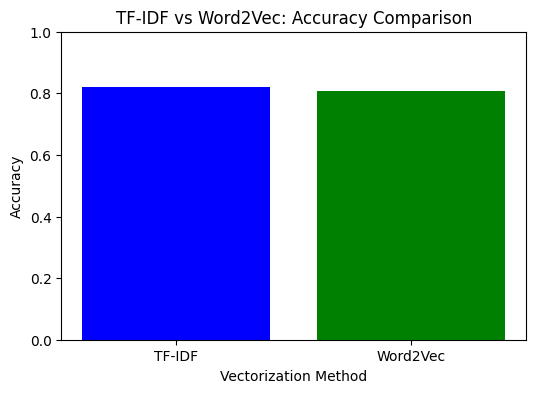

In [15]:
# 畫出比較條形圖
methods = ['TF-IDF', 'Word2Vec']
accuracies = [accuracy_tfidf, accuracy_word2vec]

plt.figure(figsize=(6, 4))
plt.bar(methods, accuracies, color=['blue', 'green'])
plt.title('TF-IDF vs Word2Vec: Accuracy Comparison')
plt.xlabel('Vectorization Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()